In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, gc, random
from skimage.io import imread
from skimage.morphology import closing, opening, disk, label
from skimage.transform import resize
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.losses import binary_crossentropy

seed = 42
random.seed = seed
np.random.seed = seed

%matplotlib inline
dsb_data_dir = os.path.join('..', 'input','data-science-bowl-2018')
IMG_CHANNELS = 3
IMG_WIDTH = 512
IMG_HEIGHT = 512

Using TensorFlow backend.


In [2]:
def read_and_stack(in_img_list):
    return np.array((resize(np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0),(IMG_HEIGHT, IMG_WIDTH),mode='constant', preserve_range=True)/255.),dtype=np.float32)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2,y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)  

def simple_gen():
    while True:
        for _, c_row in train_img_df.iterrows():
            yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

def clean_img(x):
    return opening(closing(x, disk(1)), disk(3))

def rleToMask(rleString,height,width):
    rows,cols = height,width
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows*cols,dtype=np.uint8)
    for index,length in rlePairs:
        index -= 1
        img[index:index+length] = 255
    img = img.reshape(cols,rows)
    img = img.T
    return img

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x>cut_off)
    if lab_img.max()<1:
        lab_img[0,0] = 1 # ensure at least one prediction per image
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

def load_path(df,train):
    '''
    return df : Change ['images'] and ['masks'] to include every path to load data
    Train = False to ignore ['masks'] column
    '''
    rows = []
    group_cols = ['Stage', 'ImageId']
    if train :
        for n_group, n_rows in df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            rows += [c_row]
    else :
        for n_group, n_rows in df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            rows += [c_row]
    return pd.DataFrame(rows)  
        

def out_pred_df(test_df):
    test_img_df = load_path(test_df,train=False)
    test_img_df['images_'] = test_img_df['images'].map(read_and_stack)
    test_img_df['img_size'] = test_img_df['images'].map(lambda x : imread(x[0]).shape)
    for _,i in test_img_df.iterrows():
        if len(i['images_'].shape)==2:
            img_correct = np.expand_dims(i['images_']/255., axis=2)
            img_RG = np.append(img_correct,img_correct,2)
            img_RGB = np.append(img_RG,img_correct,2)
            i['images_'] = img_RGB
    test_img_df['images_'] = test_img_df['images_'].map(lambda x: x[:,:,:IMG_CHANNELS])
    print(test_img_df.shape[0], 'images to process')
    test_img_df['masks'] = None
    for _,row in test_img_df.iterrows():
        row['masks'] = resize(model.predict(np.expand_dims(row['images_'], 0))[0, :, :, 0],
                                  (row['img_size'][0], row['img_size'][1]),mode='constant', preserve_range=True)    
    test_img_df['rles'] = test_img_df['masks'].map(clean_img).map(lambda x: list(prob_to_rles(x)))
    out_pred_list = []
    for _, c_row in test_img_df.iterrows():
        for c_rle in c_row['rles']:
            out_pred_list+=[dict(EncodedPixels = ' '.join(np.array(c_rle).astype(str)),ImageId=c_row['ImageId'])]
    out_pred_df = pd.DataFrame(out_pred_list)
    print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
    gc.collect()
    return out_pred_df[['ImageId', 'EncodedPixels']]

def show_test_graph(test_df):
    test_img_df = load_path(test_df,train=False)
    test_img_df['images'] = test_img_df['images'].map(read_and_stack)
    for _,i in test_img_df.iterrows():
        if len(i['images'].shape)==2:
            img_correct = np.expand_dims(i['images']/255., axis=2)
            img_RG = np.append(img_correct,img_correct,2)
            img_RGB = np.append(img_RG,img_correct,2)
            i['images'] = img_RGB
    test_img_df['images'] = test_img_df['images'].map(lambda x: x[:,:,:IMG_CHANNELS])
    test_img_df['masks'] = test_img_df['images'].map(lambda x: model.predict(np.expand_dims(x, 0))[0, :, :, 0])
    n_img = 3
    fig, m_axs = plt.subplots(3, n_img, figsize = (18, 8))
    for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(),m_axs):
        c_im.imshow(d_row['images'])
        c_im.axis('off')
        c_im.set_title('Microscope')
        c_lab.imshow(d_row['masks'])
        c_lab.axis('off')
        c_lab.set_title('Predicted')
        c_clean.imshow(clean_img(d_row['masks']))
        c_clean.axis('off')
        c_clean.set_title('Clean')

## Référencement données totales (Stage1[train/test] | Stage2[test])

In [3]:
all_images = glob(os.path.join(dsb_data_dir, 'stage*', '*', '*', '*'))
all_images.remove('../input/data-science-bowl-2018/stage2_test_final/170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece/images/170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece.png')
img_df = pd.DataFrame({'path': all_images})
img_df['ImageId'] = img_df['path'].map(lambda in_path: in_path.split('/')[-3])
img_df['ImageType'] = img_df['path'].map(lambda in_path: in_path.split('/')[-2])
img_df['TrainingSplit'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[1])
img_df['Stage'] = img_df['path'].map(lambda in_path: in_path.split('/')[-4].split('_')[0])
img_df.describe()

path   ...     Stage
count                                               33214   ...     33214
unique                                              33214   ...         2
top     ../input/data-science-bowl-2018/stage1_train/7...   ...    stage1
freq                                                    1   ...     30196

[4 rows x 5 columns]

## Chargement des données d'entraînement

In [4]:
train_df = img_df.query('TrainingSplit=="train"')
train_img_df = load_path(train_df,train = True)
train_img_df.sample(1)

ImageId                        ...                                                                      masks
186  44ab6a09eedee848b072ea3acd0f4e781f9c43b8d4e3d6...                        ...                          [../input/data-science-bowl-2018/stage1_train/...

[1 rows x 4 columns]

In [5]:
train_img_df['images'] = train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
train_img_df['masks'] = train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
train_img_df.sample(1)

ImageId                        ...                                                                      masks
331  7af09f98ec299ba0658d759eebc4c34e1c98289ea6ce37...                        ...                          [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

[1 rows x 4 columns]

In [6]:
#stage1_test_df = img_df.query('Stage=="stage1"')
#stage1_test_df = stage1_test_df.query('TrainingSplit=="test"')
#stage_1_test_img_df = load_path(stage1_test_df,train = False)
#stage1_solution = pd.read_csv(os.path.join('..', 'input','stage1-test-solution','stage1_solution.csv'))
#rows=[]
#for i,row in stage1_solution.iterrows():
#    rows.append(rleToMask(row['EncodedPixels'],row['Height'],row['Width']))
#stage1_solution['masks']=pd.Series(rows)
#rows=[]
#for n_group, n_rows in stage1_solution.groupby(["ImageId"]):
#    c_row = {"ImageId": n_group}
#    c_row['masks'] = np.squeeze(n_rows['masks'].values.tolist())
#    rows += [c_row]
#merge = pd.merge(stage_1_test_img_df, pd.DataFrame(rows), on='ImageId')
#merge['masks'] = merge['masks'].map(lambda y : resize(np.sum(np.stack(y, 0), 0),(IMG_HEIGHT, IMG_WIDTH),mode='constant', preserve_range=True)/255.0).map(lambda x: x.astype(int))
#merge['images'] = merge['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
#train_img_df = pd.concat([train_img_df,merge])

## Visualisation des données d'entraînement

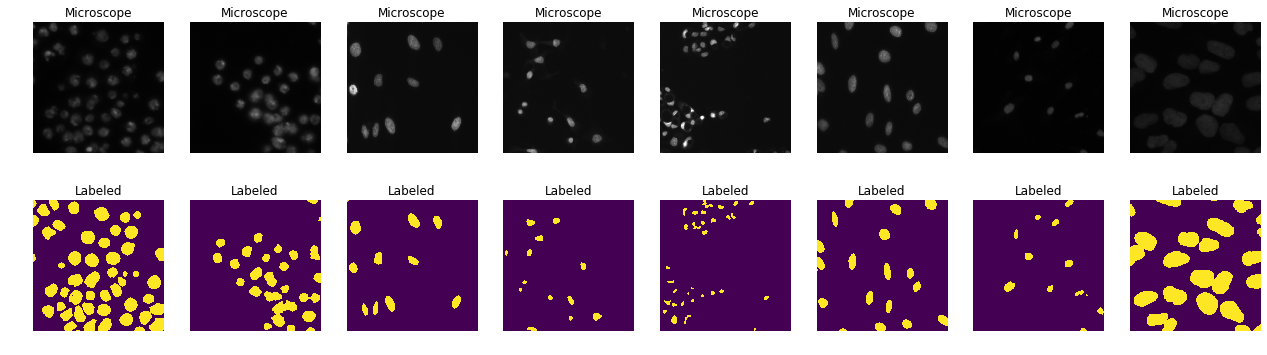

In [7]:
n_img = 8
fig, m_axs = plt.subplots(2, n_img, figsize = (22, 6))
for (_, c_row), (c_im, c_lab) in zip(train_img_df.tail(n_img).iterrows(), 
                                     m_axs.T):
    c_im.imshow(c_row['images'])
    c_im.axis('off')
    c_im.set_title('Microscope')
    
    c_lab.imshow(c_row['masks'])
    c_lab.axis('off')
    c_lab.set_title('Labeled')

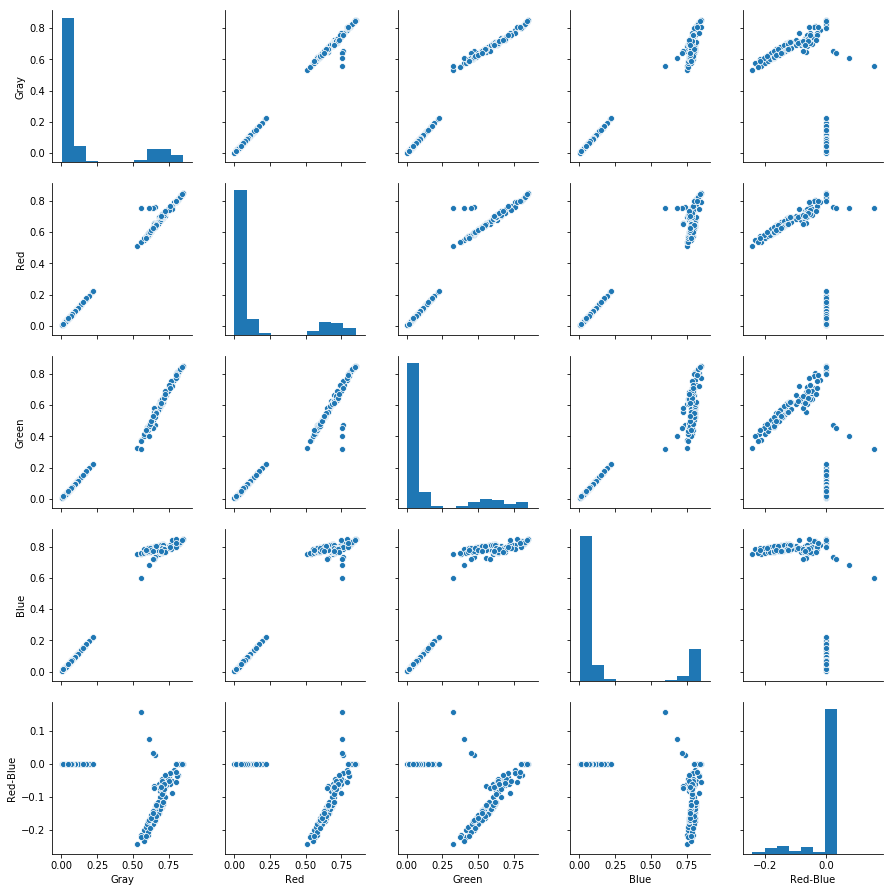

In [8]:
train_img_df['Red'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]))
train_img_df['Green'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,1]))
train_img_df['Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,2]))
train_img_df['Gray'] = train_img_df['images'].map(lambda x: np.mean(x))
train_img_df['Red-Blue'] = train_img_df['images'].map(lambda x: np.mean(x[:,:,0]-x[:,:,2]))
sns.pairplot(train_img_df[['Gray', 'Red', 'Green', 'Blue', 'Red-Blue']])

In [9]:
train_img_df['images'].map(lambda x: x.shape).value_counts()

(512, 512, 3)    670
Name: images, dtype: int64

## Construction CNN

In [10]:
model = Sequential()
model.add(BatchNormalization(input_shape = (None, None, IMG_CHANNELS),name = 'NormalizeInput'))
model.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
model.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
model.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
model.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))
model.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
model.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
model.compile(optimizer = 'adam',loss = bce_dice_loss, metrics = [mean_iou])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None

### Training

In [11]:
h = model.fit_generator(simple_gen(),steps_per_epoch=train_img_df.shape[0]//16,epochs = 15)

Epoch 1/15
41/41 [==============================] - 4s 102ms/step - loss: 0.0362 - mean_iou: 0.1737
Epoch 2/15
41/41 [==============================] - 1s 36ms/step - loss: -0.3144 - mean_iou: 0.1963
Epoch 3/15
41/41 [==============================] - 2s 37ms/step - loss: -0.4138 - mean_iou: 0.2048
Epoch 4/15
41/41 [==============================] - 1s 36ms/step - loss: -0.4359 - mean_iou: 0.2132
Epoch 5/15
41/41 [==============================] - 2s 37ms/step - loss: -0.4614 - mean_iou: 0.2213
Epoch 6/15
41/41 [==============================] - 2s 37ms/step - loss: -0.4118 - mean_iou: 0.2313
Epoch 7/15
41/41 [==============================] - 2s 37ms/step - loss: -0.5059 - mean_iou: 0.2410
Epoch 8/15
41/41 [==============================] - 2s 37ms/step - loss: -0.4461 - mean_iou: 0.2483
Epoch 9/15
41/41 [==============================] - 1s 36ms/step - loss: -0.5020 - mean_iou: 0.2514
Epoch 10/15
41/41 [==============================] - 1s 36ms/step - loss: -0.4960 - mean_iou: 0.2550

In [12]:
pd.DataFrame(h.history)

loss  mean_iou
0   0.036186  0.173677
1  -0.314374  0.196299
2  -0.413776  0.204830
3  -0.435923  0.213169
4  -0.461378  0.221297
5  -0.411781  0.231308
6  -0.505945  0.241029
7  -0.446127  0.248309
8  -0.502002  0.251384
9  -0.496019  0.255049
10 -0.399011  0.256255
11 -0.562765  0.257044
12 -0.550387  0.260547
13 -0.649238  0.264340
14 -0.508161  0.271149

## Prédictions

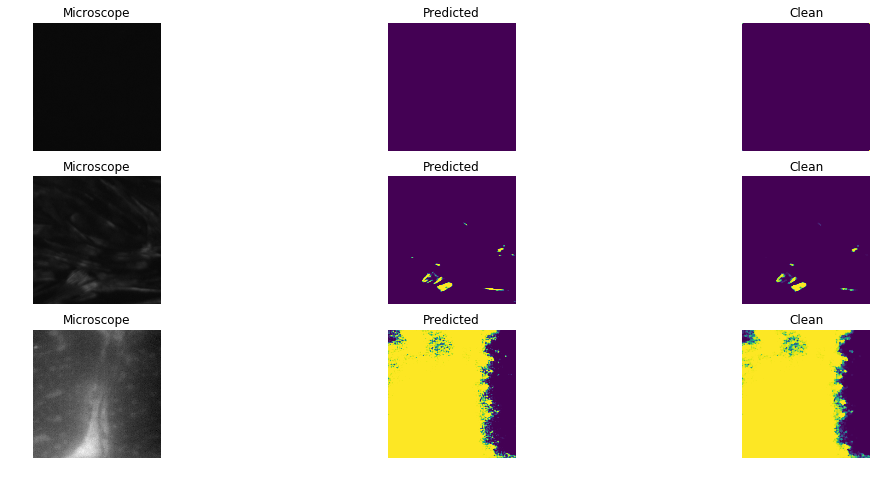

In [13]:
test_df_tot = img_df.query('TrainingSplit=="test"')
test_df_stage_2 = test_df_tot.query('Stage=="stage2"')
show_test_graph(test_df_stage_2.sample(3))

In [14]:
l = int(np.floor(test_df_stage_2.shape[0]/4))
test_one_df = test_df_stage_2[:l]
test_two_df = test_df_stage_2[l:l*2]
test_three_df = test_df_stage_2[l*2:l*3]
test_four_df = test_df_stage_2[l*3:]

In [15]:
gc.collect()

15052

In [16]:
default = pd.DataFrame([dict(ImageId='170bc41b2095177cccd3d4c8977c619147580f1d93b4fe9701eddd77736d4ece',
                   EncodedPixels = '1 1')])

pd.concat([out_pred_df(test_one_df),
           out_pred_df(test_two_df),
           out_pred_df(test_three_df),
           out_pred_df(test_four_df),
           default]).reindex(columns = ['ImageId', 'EncodedPixels']).to_csv('predictions.csv', index = False)

754 images to process
11357 regions found for 754 images
754 images to process
11646 regions found for 754 images
754 images to process
11216 regions found for 754 images
756 images to process
11900 regions found for 756 images


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
